In [1]:
"""# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify"""

'# Install the required libraries\n#SAM\n!pip install git+https://github.com/facebookresearch/segment-anything.git\n#Transformers\n!pip install -q git+https://github.com/huggingface/transformers.git\n#Datasets to prepare data and monai if you want to use special loss functions\n!pip install datasets\n!pip install -q monai\n#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)\n!pip install patchify'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

import polars as pl
import collections as cl
import sklearn as sk
import skimage.io as skio

In [3]:
src = "/run/media/capitan/Emu/blastodata_orig"
csv = "/home/capitan/Documents/Code/MedSAM/bbox.csv"
save_dir = "/home/capitan/Documents/Code/MedSAM/trained_model"

# GET IMAGE PATHS
img_paths = {}
for root, dirs, files in os.walk(src, topdown=True):
    for f in files:
        img_paths[f.lower()] = os.path.join(root, f)
# LOAD IMAGES
df = (
    pl.scan_csv(csv)
    .select(["Image", "x1", "y1", "x2", "y2", "Label"])
    .with_columns(pl.col("Image").str.replace(r"^[^/]*/", "").alias("Image"))
    .collect()
)
rows = df.to_dicts()

# MATCH ROWS
valid_rows = []
for r in rows:
    name = r["Image"].lower()
    if name in img_paths:
        r["FullImagePath"] = img_paths[name]
        valid_rows.append(r)
    else:
        print(f"Not found on disk: {r['Image']}")

# print(f"Matched {len(valid_rows)} of {len(rows)} CSV entries")

# SUBSAMPLE DATASET
random.seed(42)

class_groups = cl.defaultdict(list)
for r in valid_rows:
    class_groups[r["Label"]].append(r)

n_samples_total = 200
n_classes = len(class_groups)
samples_per_class = n_samples_total // n_classes

subsampled_rows = []
for label, rows_list in class_groups.items():
    n = min(samples_per_class, len(rows_list))
    subsampled_rows.extend(random.sample(rows_list, n))

# print(f"Subsampled {len(subsampled_rows)} rows with balanced classes")

train_rows, test_rows = sk.model_selection.train_test_split(
    subsampled_rows,
    test_size=0.2,
    random_state=42,
    stratify=[r["Label"] for r in subsampled_rows],
)
# print(f"Train samples: {len(train_rows)}, Test samples: {len(test_rows)}")

In [4]:
from PIL import Image
import numpy as np
import cv2
import os
def load_images_and_masks(rows, target_size=(1024, 1024), method='as_is'):
    """
    Load images, resize to 1024×1024, and generate circular masks.
    
    Args:
        rows: List of dicts with FullImagePath, x1, y1, x2, y2, Label
        target_size: Target size (default 1024x1024)
        method: 'as_is' if bbox is already in 1024x1024 coords,
                'scale' if bbox needs scaling from original image
    
    Returns:
        images, masks, labels (all as lists of numpy arrays)
    """
    images, masks, labels = [], [], []
    
    for r in rows:
        img_path = r.get("FullImagePath")
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            continue
        
        try:
            # Load image
            img = Image.open(img_path).convert("RGB")
            orig_w, orig_h = img.size
            
            # Resize to 1024x1024
            img = img.resize(target_size, Image.BILINEAR)
            img_np = np.array(img)
            h, w = img_np.shape[:2]
            
            # Get bbox coordinates
            if method == 'as_is':
                # BBox is already in 1024x1024 space
                x1 = int(np.clip(r["x1"], 0, w - 1))
                y1 = int(np.clip(r["y1"], 0, h - 1))
                x2 = int(np.clip(r["x2"], 0, w - 1))
                y2 = int(np.clip(r["y2"], 0, h - 1))
            
            elif method == 'scale':
                # BBox needs scaling from original image size
                scale_x = w / orig_w
                scale_y = h / orig_h
                x1 = int(np.clip(r["x1"] * scale_x, 0, w - 1))
                y1 = int(np.clip(r["y1"] * scale_y, 0, h - 1))
                x2 = int(np.clip(r["x2"] * scale_x, 0, w - 1))
                y2 = int(np.clip(r["y2"] * scale_y, 0, h - 1))
            
            else:
                raise ValueError(f"Unknown method: {method}")
            
            # Validate bbox
            if x2 <= x1 or y2 <= y1:
                print(f"Invalid bbox for {img_path}: ({x1}, {y1}, {x2}, {y2})")
                continue
            
            # Calculate circle parameters
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            radius = int(min((x2 - x1), (y2 - y1)) / 2)
            
            if radius <= 0:
                print(f"Zero-radius circle for {img_path}")
                continue
            
            # Create mask
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.circle(mask, (cx, cy), radius, 255, -1)  # Use 255 for visibility
            
            # Verify mask is not empty
            if np.count_nonzero(mask) == 0:
                print(f"   Empty mask generated for {img_path}")
                print(f"   BBox: ({x1}, {y1}, {x2}, {y2}), Center: ({cx}, {cy}), Radius: {radius}")
                continue
            
            images.append(img_np)
            masks.append(mask)
            labels.append(r["Label"])
        
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    
    print(f"Loaded {len(images)} valid images @ {target_size}")
    return images, masks, labels


# --- Load training and test data ---
large_images, large_masks, labels_train = load_images_and_masks(train_rows)
large_images_test, large_masks_test, labels_test = load_images_and_masks(test_rows)

print(f"Train: {len(large_images)} images + masks @ 1024×1024")
print(f"Test:  {len(large_images_test)} images + masks @ 1024×1024")

Loaded 160 valid images @ (1024, 1024)
Loaded 40 valid images @ (1024, 1024)
Train: 160 images + masks @ 1024×1024
Test:  40 images + masks @ 1024×1024


In [5]:
import numpy as np

# Collect all shapes (height, width)
shapes = np.array([img.shape[:2] for img in large_images])  # ignore channels

# Print some basic stats
print("Number of images:", len(shapes))
print("Min shape (H, W):", shapes.min(axis=0))
print("Max shape (H, W):", shapes.max(axis=0))
print("Mean shape (H, W):", shapes.mean(axis=0).astype(int))
print("Median shape (H, W):", np.median(shapes, axis=0).astype(int))

Number of images: 160
Min shape (H, W): [1024 1024]
Max shape (H, W): [1024 1024]
Mean shape (H, W): [1024 1024]
Median shape (H, W): [1024 1024]


In [6]:
#Desired patch size for smaller images and step size.
patch_size = 1024
step = 1024

In [7]:
import numpy as np

large_images = np.array(large_images)  # shape: (N, H, W, 3)
large_masks  = np.array(large_masks)   # shape: (N, H, W)

In [8]:

all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size, large_image.shape[2]), step=step)
    #patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            #single_patch_img = patches_img[i,j,:,:]
            single_patch_img = patches_img[i, j, 0, :, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    #patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)
    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            #single_patch_mask = patches_mask[i,j,:,:]
            #single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [9]:
images.shape, masks.shape

((160, 1024, 1024, 3), (160, 1024, 1024))

In [10]:


# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (160, 1024, 1024, 3)
Mask shape: (160, 1024, 1024)


In [11]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [12]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 160
})

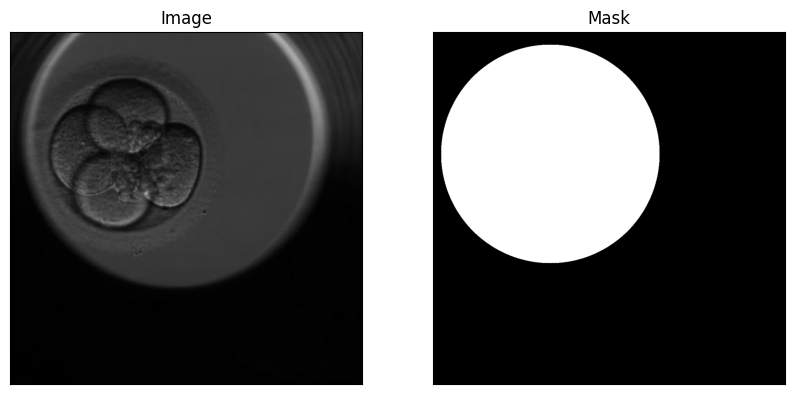

In [13]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [14]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [15]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [16]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [17]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [18]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (1024, 1024)


In [19]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 1024, 1024])


In [21]:
batch["ground_truth_mask"].shape

torch.Size([2, 1024, 1024])

In [22]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [23]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [24]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize, interpolate

#Training loop
num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch_idx, batch in enumerate(tqdm(train_dataloader)):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      
      # Debug prints for the first batch
      if batch_idx == 0:
          print(f"Predicted masks shape: {predicted_masks.shape}")
          print(f"Ground truth masks shape: {ground_truth_masks.shape}")
      
      # Resize ground truth masks to match predicted masks size
      # SAM outputs masks at lower resolution than input
      if ground_truth_masks.shape[-2:] != predicted_masks.shape[-2:]:
          ground_truth_masks = interpolate(ground_truth_masks.unsqueeze(1), 
                                         size=predicted_masks.shape[-2:], 
                                         mode='bilinear', 
                                         align_corners=False).squeeze(1)
      
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  1%|▏         | 1/80 [00:01<01:20,  1.02s/it]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


EPOCH: 0
Mean loss: 0.3435465535148978


  1%|▏         | 1/80 [00:00<00:56,  1.40it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 1
Mean loss: 0.2062937520444393


  1%|▏         | 1/80 [00:00<00:56,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 2
Mean loss: 0.16340285986661912


  1%|▏         | 1/80 [00:00<00:57,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


EPOCH: 3
Mean loss: 0.13111149091273547


  1%|▏         | 1/80 [00:00<00:56,  1.41it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 4
Mean loss: 0.10925358645617962


  1%|▏         | 1/80 [00:00<00:56,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 5
Mean loss: 0.09573947531171142


  1%|▏         | 1/80 [00:00<00:55,  1.42it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


EPOCH: 6
Mean loss: 0.08198756561614573


  1%|▏         | 1/80 [00:00<00:56,  1.40it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 7
Mean loss: 0.07555049653165043


  1%|▏         | 1/80 [00:00<00:57,  1.38it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 8
Mean loss: 0.07186089931055903


  1%|▏         | 1/80 [00:00<00:56,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 9
Mean loss: 0.06304094740189611


  1%|▏         | 1/80 [00:00<00:57,  1.38it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 10
Mean loss: 0.061540267895907164


  1%|▏         | 1/80 [00:00<00:57,  1.38it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:58<00:00,  1.37it/s]


EPOCH: 11
Mean loss: 0.059596101148054005


  1%|▏         | 1/80 [00:00<00:56,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 12
Mean loss: 0.0568385535851121


  1%|▏         | 1/80 [00:00<00:56,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 13
Mean loss: 0.05578534477390349


  1%|▏         | 1/80 [00:00<00:57,  1.38it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


EPOCH: 14
Mean loss: 0.053911564871668816


  1%|▏         | 1/80 [00:00<00:56,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:58<00:00,  1.37it/s]


EPOCH: 15
Mean loss: 0.051232219906523824


  1%|▏         | 1/80 [00:00<00:56,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 16
Mean loss: 0.04735778290778399


  1%|▏         | 1/80 [00:00<00:56,  1.40it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.38it/s]


EPOCH: 17
Mean loss: 0.04608532693237066


  1%|▏         | 1/80 [00:00<00:56,  1.39it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.39it/s]


EPOCH: 18
Mean loss: 0.04427267611026764


  1%|▏         | 1/80 [00:00<00:57,  1.36it/s]

Predicted masks shape: torch.Size([2, 1, 256, 256])
Ground truth masks shape: torch.Size([2, 1024, 1024])


100%|██████████| 80/80 [00:57<00:00,  1.38it/s]

EPOCH: 19
Mean loss: 0.044536300795152785


In [25]:
"""from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.amp import autocast, GradScaler

# Training loop
num_epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

# Initialize GradScaler for mixed precision
scaler = GradScaler(device)

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # Use autocast for mixed precision
        with autocast(device_type=device):
            # forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                          input_boxes=batch["input_boxes"].to(device),
                          multimask_output=False)
            
            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
        
        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        
        # optimize
        scaler.step(optimizer)
        scaler.update()
        
        epoch_losses.append(loss.item())
    
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')"""

'from tqdm import tqdm\nfrom statistics import mean\nimport torch\nfrom torch.nn.functional import threshold, normalize\nfrom torch.amp import autocast, GradScaler\n\n# Training loop\nnum_epochs = 1\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nmodel.to(device)\nmodel.train()\n\n# Initialize GradScaler for mixed precision\nscaler = GradScaler(device)\n\nfor epoch in range(num_epochs):\n    epoch_losses = []\n    for batch in tqdm(train_dataloader):\n        # Use autocast for mixed precision\n        with autocast(device_type=device):\n            # forward pass\n            outputs = model(pixel_values=batch["pixel_values"].to(device),\n                          input_boxes=batch["input_boxes"].to(device),\n                          multimask_output=False)\n            \n            # compute loss\n            predicted_masks = outputs.pred_masks.squeeze(1)\n            ground_truth_masks = batch["ground_truth_mask"].float().to(device)\n            loss = seg_loss(predicte

In [26]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "models/mito_model_checkpoint.pth")

# INFERENCE

In [27]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("models/mito_model_checkpoint.pth"))

<All keys matched successfully>

In [28]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionSdpaAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm((25

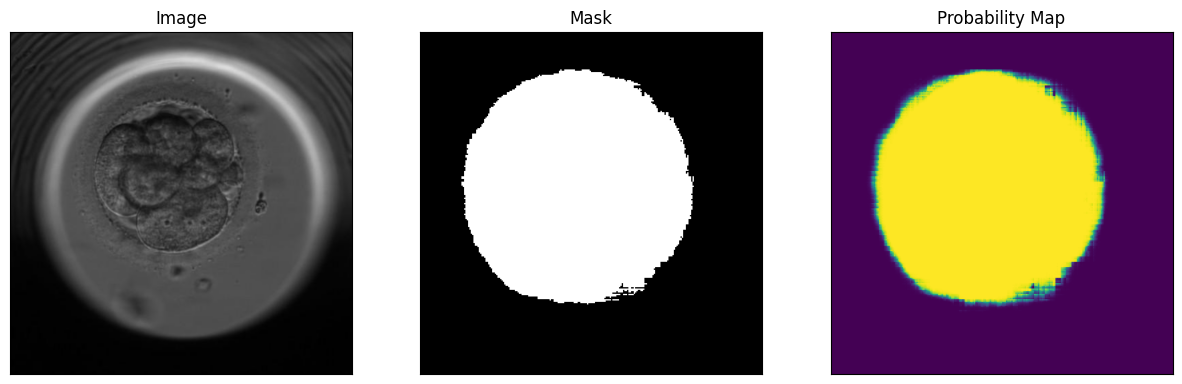

In [45]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [30]:
"""#Apply a trained model on large image
large_images_test = np.array(large_images_test)  # shape: (N, H, W, 3)
#large_masks_test  = np.array(large_masks_test)   # shape: (N, H, W)
large_test_image = large_images_test[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
"""
# Apply a trained model on large image
large_images_test = np.array(large_images_test)  # shape: (N, H, W, 3)
large_test_image = large_images_test[1]

# Include the channel dimension in patch_size
patches = patchify(large_test_image, (1024, 1024, 3), step=1024)

In [31]:

"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)
print(np.array(input_points).shape)

(1, 1, 100, 2)


In [32]:
patches.shape

(1, 1, 1, 1024, 1024, 3)

In [33]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2


# Selectelected patch for segmentation
#random_array = patches[i, j]
random_array = patches[i, j].squeeze()


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1